### Data source: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Objectives:
Build a multi-headed model capable of detecting and assigning probabilities for different types of of toxicity such as: 
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate

The dataset comprises of comments from Wikipedia's talk page (ie. discussion) pages.

In [ ]:
'''
Create a new environment

1. Open Anaconda Prompt
2. Enter 'conda env create -f toxic_test.yml'
3. Enter 'python -m ipykernel install --user --name toxic --display-name toxic

'''



## Import relevant libraries and load the data

In [1]:
# Install the nltk library in case you have not yet installed it
# pip stands for preferred installer program under Python Package Index (PyPI)

!pip install nltk

In [2]:
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [3]:
# In case there is a bug, just download stopwords again.
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\poude_9elal6v\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Stopwords are a list of 'useless' words
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Load the CSV and take a peek at 1st 5 rows

In [5]:
data = pd.read_csv('C:/Fyp/fypenv/dataset/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


A clean dataset with no missing values. Sweet!

## Let's see how the 1st 3 comments look like

In [7]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [9]:
data['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

The comments are dirty with '\n' values, symbols, numbers that will not be useful for analysis. We will be removing these further down the pipeline.

## Exploratory Data Analysis

In [10]:
# Check percentage of comments that are toxic compared to normal comments
data.toxic.value_counts(normalize=True)

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64

Cool. It seems that 90% of the comments fall in the toxic category.

In [11]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=data.iloc[:,2:].sum()

In [13]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [14]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 800x400 with 0 Axes>

In [15]:
num_rows = len(data)
print(num_rows)

159571


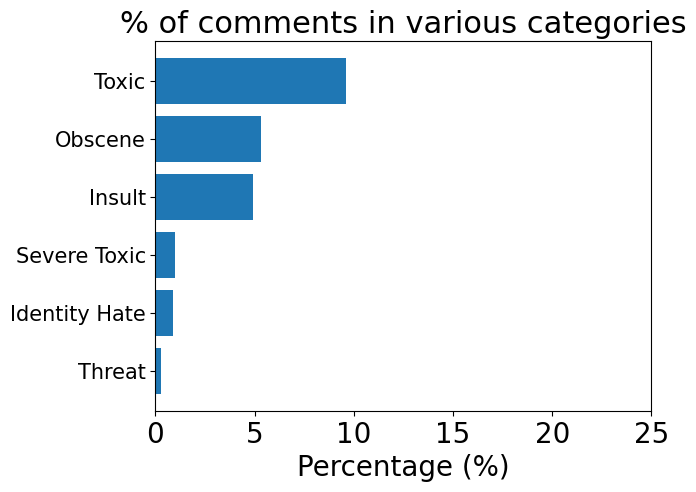

In [16]:
# Create a bar graph 
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


## Preprocess the text

In [17]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

## Separate our dataset into 6 sections. Each section is comment + 1 category.

In [18]:
data_tox = data.loc[:,['id','comment_text','toxic']]

In [19]:
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [20]:
data_tox['comment_text'][1]

'd aww  he matches this background colour i m seemingly stuck with  thanks    talk       january       utc '

In [21]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [22]:
data_obs = data.loc[:,['id','comment_text','obscene']]

In [23]:
data_thr = data.loc[:,['id','comment_text','threat']]

In [24]:
data_ins = data.loc[:,['id','comment_text','insult']]

In [25]:
data_ide = data.loc[:,['id','comment_text','identity_hate']]

## Creating WordCloud
### Useful to show the words which occur most frequently for each category. Warning: Profanity ahead.

In [26]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [27]:
!pip install wordcloud

In [28]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

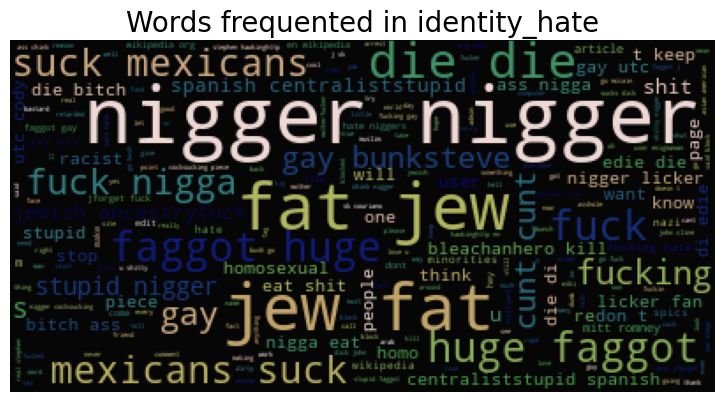

In [29]:
wordcloud(data_ide,'identity_hate')

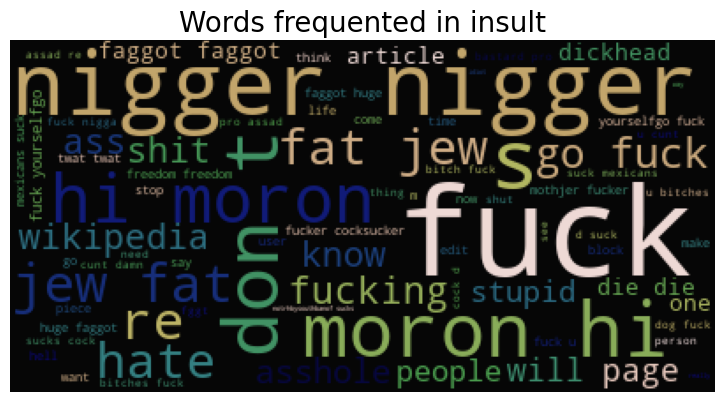

In [30]:
wordcloud(data_ins, 'insult')

#### Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

#### We can deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

#### For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [31]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [32]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [33]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [34]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [35]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [36]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

Cool. We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [37]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [38]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [39]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [40]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [41]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [42]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [43]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [44]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_****_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [45]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


### Create simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [46]:
'''
df_done: data_tox_done, data_sev_done, ...
label: toxic, severe_toxic, ...
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1


### Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [ ]:
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram)
vectorizer values: CountVectorizer, TfidfVectorizer
ngram_range values: (1,1) for unigram, (2,2) for bigram
'''

import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

# Various permutations of the dataset, category, vectorizer and n-gram

# cv_tf_train_test(data_tox_done, 'toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', CountVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', CountVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', CountVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', CountVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', CountVectorizer, (1,1))

# cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
# cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))


In [ ]:

t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

In [ ]:

t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

In [ ]:

t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

In [ ]:

t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

In [ ]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

In [ ]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all


### Transpose the combined F1 dataframe to make it suitable for presentation on a graph

In [ ]:
f1_all_trp = f1_all.transpose()
f1_all_trp

In [ ]:
sns.lineplot(data=f1_all_trp, size=[10,10], markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

# Repeat this for CountVectorizer as well

LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest).

### Test if our code actually works. Probability of the comment falling in various categories should be output.

In [ ]:
data_tox_done.head()

In [47]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

svm = LinearSVC()

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
svm.fit(X_train_fit, y_train)
svm.predict(X_test_fit)



c:\Fyp\fypenv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample comments
comment1 = ['This is a toxic comment.']
comment2 = ['What is up garden apple doing']

# Concatenate comments for TF-IDF vectorization
all_comments = comment1 + comment2

# Create TF-IDF vectorizer
tfv = TfidfVectorizer()
X_train_tfv = tfv.fit_transform(all_comments)

# Labels for the example
y_train = [1, 0]  # Assuming binary classification (1 for toxic, 0 for non-toxic)

# Create LinearSVC
linear_svc = LinearSVC()

# Wrap LinearSVC in CalibratedClassifierCV for probability calibration
calibrated_svc = CalibratedClassifierCV(linear_svc, method='sigmoid', cv='prefit')
calibrated_svc.fit(X_train_tfv, y_train)

# Now you can use predict_proba
comment1_vect = tfv.transform(comment1)
probabilities = calibrated_svc.predict_proba(comment1_vect)[:, 1]
print(probabilities)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Sample data splitting
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

# Create and fit the LinearSVC model
svm = LinearSVC()
svm.fit(X_train_fit, y_train)

# Create CalibratedClassifierCV and fit it with the LinearSVC model
calibrated_svc = CalibratedClassifierCV(svm, method='sigmoid', cv='prefit')
calibrated_svc.fit(X_train_fit, y_train)

# Now you can use the calibrated_svc for prediction
predictions = calibrated_svc.predict(X_test_fit)


In [ ]:
probabilities = calibrated_svc.predict_proba(X_test_fit)[:, 1] 
print(probabilities)

Random forest has assigned a probability of 1 that comment 1 ('you piece of shit') is toxic. Comment 2 has only a low toxicity probability of 0.16.

## Pickling trained RandomForest models for all categories. 

#### We choose Random Forest instead of LinearSVC although the latter performs well, as RDF has predict_proba function and LinearSVC does not. We need to output a probability score for each comment, remember?

In [ ]:
import pickle

### We have to pickle not only the TF-IDF vectorizer object, but also the RDF model trained on the related vectorizer.

In [ ]:
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Initiate a Tfidf vectorizer
    tfv = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
    
    # Convert the X data into a document term matrix dataframe
    X_vect = tfv.fit_transform(X)  
    
    # Save the column labels (i.e., the vocabulary)
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
    
    # Use LinearSVC instead of RandomForestClassifier
    svm = LinearSVC()
    svm.fit(X_vect, y)

    # Create a new pickle file based on SVM
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(svm, f)

# Example usage:
# Assuming you have a DataFrame 'df' with a 'toxic' column, you can pickle the SVM model and vectorizer as follows:
# pickle_model(df, 'toxic')


### Create a loop to create pickle files all at one shot

In [ ]:
'''
OPTIONAL STEP. Pickled file already available on Github.

datalist = [data_tox_done, data_sev_done, data_obs_done, data_ins_done, data_thr_done, data_ide_done]
label = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']

for i,j in zip(datalist,label):
    pickle_model(i, j)
    
'''

In [ ]:
import pickle

def load_model_and_vectorizer(label):
    # Load the TfidfVectorizer
    with open(r"{}.pkl".format(label + '_vect'), "rb") as f:
        tfv = pickle.load(f)
    
    # Load the SVM model
    with open(r"{}.pkl".format(label + '_model'), "rb") as f:
        svm_model = pickle.load(f)
    
    return tfv, svm_model

def test_model_on_test_data(test_data, label):
    # Load the TfidfVectorizer and SVM model
    tfv, svm_model = load_model_and_vectorizer(label)

    # Preprocess the test data using the TfidfVectorizer
    test_data_vect = tfv.transform(test_data)

    # Make predictions using the SVM model
    predictions = svm_model.predict(test_data_vect)
    probabilities = svm_model.decision_function(test_data_vect)

    return predictions, probabilities

# Example usage:
# Assuming you have a test DataFrame 'test_df' with a 'comment_text' column
test_data = test_sev['comment_text']
label = 'toxic'

# Test the SVM model on the test data
predictions, probabilities = test_model_on_test_data(test_data, label)

# Now 'predictions' contains the predicted labels (0 or 1), and 'probabilities' contains the decision values
# (which can be converted to probabilities if needed)
